# Import Libraries

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.io import imread
from skimage.transform import resize
import tarfile
import urllib.request
import os
import math
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import deque
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [2]:
!pip install kagglehub

import kagglehub

In [3]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9cbb38609614c678d00f8324ce45e75dde19cfde1a6247a5f8da3c54ea7f3d09
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import shap
import tensorflow as tf

# Read Dataset

In [5]:
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [6]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


In [7]:
print(os.listdir(path))

['Training', 'Testing']


In [8]:
train_dir = os.path.join(path, "Training")
test_dir = os.path.join(path, "Testing")


In [9]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [10]:
def count_images_in_dir(root_dir):
    counts = {}
    for cls in sorted(os.listdir(root_dir)):
        cls_path = os.path.join(root_dir, cls)
        if os.path.isdir(cls_path):
            n = sum(fname.lower().endswith(('.png', '.jpg', '.jpeg'))
                    for fname in os.listdir(cls_path))
            counts[cls] = n
    return counts

print("Train counts:", count_images_in_dir(train_dir))
print("Test counts: ", count_images_in_dir(test_dir))

Train counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Test counts:  {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


# Data Augmentation

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=42
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed=42
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


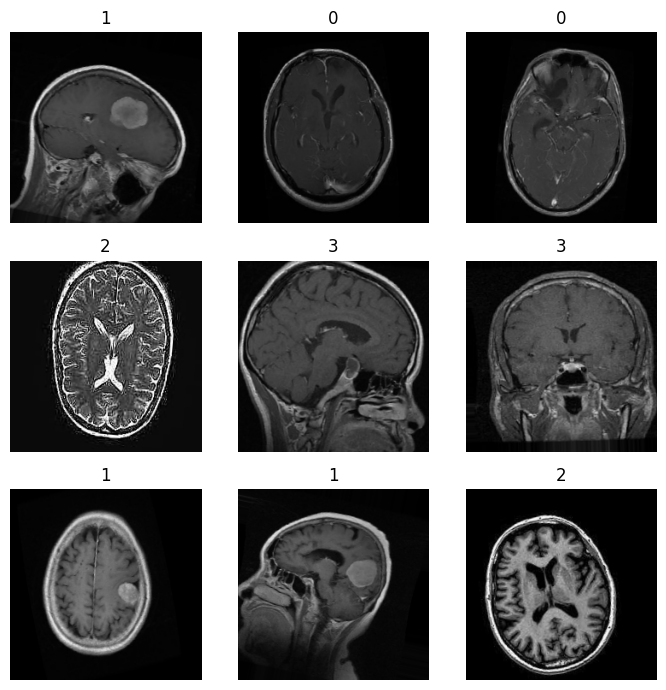

In [12]:
plt.figure(figsize=(7,7))
imgs, labels = next(train_gen)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i])
    plt.title(np.argmax(labels[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

# Build the model

In [13]:
NUM_CLASSES = train_gen.num_classes


def build_model(lr, dropout_rate, dense_units):
    K.clear_session()
    base = MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")
    base.trainable = False

    inp = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = Lambda(lambda img: tf.image.resize(img, (224,224)))(inp)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [14]:
def evaluate_config(config, epochs=3, patience=3):
    model = build_model(config["lr"], config["dropout"], config["dense_units"])

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[early_stop],
        verbose=0
    )

    final_acc = max(history.history["val_accuracy"])
    tf.keras.backend.clear_session()
    del model
    gc.collect()
    return final_acc, history.history

def random_initial_solution(search_space):
    return {k: random.choice(v) for k, v in search_space.items()}

def neighborhood_of(solution, search_space):
    neigh = []
    for param, vals in search_space.items():
        for v in vals:
            if v != solution[param]:
                new_sol = copy.deepcopy(solution)
                new_sol[param] = v
                neigh.append(new_sol)
    return neigh

In [15]:
search_space = {
    "lr": [1e-3, 1e-4, 5e-5],
    "dense_units": [128, 256, 512],
    "dropout": [0.3, 0.4, 0.5]
}

---

# Visualization

## 1. Loss / Training

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history,title="Model Training History",save_path=None,max_epochs=7):
    """
    Plots accuracy and loss curves for a given Keras history object.
    Shows only the first max_epochs epochs.
    """

    acc = history.history.get('accuracy', [])[:max_epochs]
    val_acc = history.history.get('val_accuracy', [])[:max_epochs]
    loss = history.history.get('loss', [])[:max_epochs]
    val_loss = history.history.get('val_loss', [])[:max_epochs]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    max_val_acc = max(val_acc) if val_acc else None
    min_val_loss = min(val_loss) if val_loss else None

    return max_val_acc, min_val_loss


# 2.Confusion Matrix

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, data_gen, class_names=None, title="Confusion Matrix"):

    # True labels
    y_true = data_gen.classes

    # Model predictions
    y_pred_probs = model.predict(data_gen, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

    return cm


# XAI Functions

##  3.LIME

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def explain_with_lime(model, data_gen, num_samples=3):
    explainer = lime_image.LimeImageExplainer()

    for i in range(num_samples):
        # get first image from batch
        img, label = data_gen[i]
        img_array = img[0]  # shape (H,W,3)

        # convert to uint8 [0-255] if it's float
        if img_array.dtype != np.uint8:
            img_array_uint8 = (img_array * 255).astype(np.uint8)
        else:
            img_array_uint8 = img_array

        explanation = explainer.explain_instance(
            img_array_uint8.astype(np.double),
            classifier_fn=lambda x: model.predict(x / 255.0),  # normalize inside
            top_labels=3,
            hide_color=0,
            num_samples=1000
        )

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=False,
            num_features=5,
            hide_rest=False
        )

        plt.imshow(mark_boundaries(temp / 255.0, mask))
        plt.title(f"LIME Explanation - True: {label[0]}")
        plt.axis('off')
        plt.show()


# 4. Shap

In [19]:
!pip install shap


In [20]:
import numpy as np
import shap
import tensorflow as tf


In [21]:
def explain_with_shap_robust(model, val_gen, num_samples=2):
    print("Gathering data...")
    x_batch, _ = val_gen[0]
    test_images = x_batch[:num_samples]

    # Check current range of data
    d_min, d_max = test_images.min(), test_images.max()
    print(f"Data range in generator: {d_min:.2f} to {d_max:.2f}")

    # --- THE FIX: Robust Prediction Wrapper ---
    def f(X):
        # 1. Ensure data is float32 (models are picky)
        X = np.array(X, dtype=np.float32)

        # 2. OPTIONAL: Auto-normalization fix
        # If your model expects 0-1 but X is 0-255, divide by 255.
        # Uncomment the lines below if your data range printed above is 0-255
        # if X.max() > 1.0:
        #     X = X / 255.0

        return model.predict(X, verbose=0)

    # Use a simpler masker to debug (blurring)
    masker = shap.maskers.Image("blur(28,28)", test_images[0].shape)

    # Create Explainer
    explainer = shap.Explainer(f, masker)

    print(f"Computing SHAP for {num_samples} images...")

    # --- KEY CHANGE: output_rank_order ---
    # This forces SHAP to explain the TOP predicted class, not just index 0.
    shap_values = explainer(
        test_images,
        max_evals=500,
        batch_size=50,
        outputs=shap.Explanation.argsort.flip[:1] # Explain the top class!
    )

    print("Plotting...")
    shap.image_plot(shap_values)


#5. GradCam

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2


In [23]:

def explain_gradcam_safe_polish(model, val_gen, num_samples=3):
    print("Running Safe Polished Grad-CAM...")

    # 1. Setup Base/Head models
    base_layer_index = None
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.Model):
            base_layer_index = i
            break
    base_model = model.layers[base_layer_index]
    head_layers = model.layers[base_layer_index + 1:]

    x_batch, _ = val_gen[0]

    for i in range(num_samples):
        img = x_batch[i]
        img_tensor = np.expand_dims(img, axis=0)

        # 2. Get Gradients
        with tf.GradientTape() as tape:
            inputs = tf.cast(img_tensor, tf.float32)
            conv_outputs = base_model(inputs)
            tape.watch(conv_outputs)

            preds = conv_outputs
            for layer in head_layers:
                preds = layer(preds)

            # Print prediction to confirm we are explaining the Tumor class
            top_class_index = tf.argmax(preds[0])
            print(f"Image {i}: Explaining Class {top_class_index.numpy()}")
            class_channel = preds[:, top_class_index]

        grads = tape.gradient(class_channel, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap).numpy()

        # 3. Clean & Smooth (The Safe Way)
        heatmap = np.maximum(heatmap, 0)

        # Smooth Resize (Cubic interpolation gets rid of blocks)
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

        # Normalize 0-1
        if np.max(heatmap) != 0:
            heatmap = heatmap / np.max(heatmap)

        # --- REMOVED AGGRESSIVE THRESHOLDS ---
        # We only apply a very weak threshold to clean faint smoke
        heatmap[heatmap < 0.05] = 0

        # 4. Colorize & Overlay
        heatmap_uint8 = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap_uint8]

        if img.max() > 1.0: img = img / 255.0

        # Overlay
        overlay = img * 0.6 + jet_heatmap * 0.4
        overlay = np.clip(overlay, 0, 1)

        # Plot
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.imshow(jet_heatmap); plt.title("Heatmap (No Blocks)"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
        plt.tight_layout(); plt.show()

# 6. DeepLift

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.ndimage as ndimage

In [25]:

def explain_smoothgrad_clean(model, val_gen, num_samples=3):
    print("Running SmoothGrad (Denoised)...")
    x_batch, _ = val_gen[0]

    for i in range(num_samples):
        img = x_batch[i]

        # --- 1. Compute Raw SmoothGrad (Same as before) ---
        img_tensor = tf.convert_to_tensor(np.expand_dims(img, 0), dtype=tf.float32)
        preds = model(img_tensor)
        pred_index = tf.argmax(preds[0])

        total_gradients = np.zeros_like(img)
        num_noise_samples = 50
        stdev = 0.15 * (np.max(img) - np.min(img)) # Slightly higher noise for better smoothing

        for n in range(num_noise_samples):
            noise = tf.random.normal(shape=img_tensor.shape, mean=0.0, stddev=stdev)
            with tf.GradientTape() as tape:
                noisy_img = img_tensor + noise
                tape.watch(noisy_img)
                score = model(noisy_img)[:, pred_index]
            grads = tape.gradient(score, noisy_img)
            total_gradients += grads

        heatmap = np.sum(np.abs(total_gradients / num_noise_samples), axis=-1)[0]

        # --- 2. CLEANING STEPS (The Magic Fixes) ---

        # A. Background Masking: If pixel is dark, set heatmap to 0
        # This removes the "static" in the black corners
        threshold = np.mean(img) * 0.2  # Threshold based on image darkness
        background_mask = np.mean(img, axis=-1) < threshold
        heatmap[background_mask] = 0

        # B. Gaussian Smoothing: Melts the "grid" into smooth blobs
        # sigma=2 is usually a sweet spot for 224x224 images
        heatmap = ndimage.gaussian_filter(heatmap, sigma=2)

        # C. Robust Normalization (Clip top 1% to make it bright)
        robust_max = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, robust_max)
        heatmap = heatmap / (robust_max + 1e-10)

        # --- 3. Plotting ---
        heatmap_uint8 = np.uint8(255 * heatmap)
        jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap_uint8]

        # Resize if needed (using scipy zoom or simple PIL resize)
        # Assuming heatmap matches img size here.

        if img.max() > 1.0: img = img / 255.0

        # Overlay: 50% Image, 50% Heatmap
        overlay = img * 0.5 + jet_heatmap * 0.5

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1); plt.imshow(img); plt.title(f"Original\nPred: {pred_index.numpy()}"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.imshow(heatmap, cmap='jet'); plt.title("Clean Heatmap"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
        plt.tight_layout(); plt.show()

# Particle Swarm

In [27]:
class Particle:
    def __init__(self, lr, dropout):
        self.position = np.array([lr, dropout])
        self.velocity = np.zeros(2)
        self.best_pos = self.position.copy()
        self.best_score = -np.inf

def evaluate_pso(lr, dropout):
    return evaluate_config({"lr": lr, "dropout": dropout, "dense_units": 256}, epochs=3)[0]

def pso_optimize(n_particles=3, n_iter=7, lr_bounds=(1e-4, 1e-3), dropout_bounds=(0.1, 0.5)):
    w, c1, c2 = 0.7, 1.5, 1.5
    swarm = [Particle(random.uniform(*lr_bounds), random.uniform(*dropout_bounds)) for _ in range(n_particles)]

    gbest_pos = None
    gbest_score = -np.inf
    pso_history = []

    for iteration in range(n_iter):
        print(f"\n=== PSO Iteration {iteration+1}/{n_iter} ===")

        for i, p in enumerate(swarm):
            score = evaluate_pso(p.position[0], p.position[1])
            print(f"Particle {i+1}: lr={p.position[0]:.6f}, dropout={p.position[1]:.3f}, val_acc={score:.4f}")

            if score > p.best_score:
                p.best_score = score
                p.best_pos = p.position.copy()

            if score > gbest_score:
                gbest_score = score
                gbest_pos = p.position.copy()

        pso_history.append((iteration + 1, gbest_score))
        print(f"PSO Best so far: {gbest_score:.4f}")

        # Update particles
        for p in swarm:
            r1, r2 = random.random(), random.random()
            p.velocity = (
                w * p.velocity
                + c1 * r1 * (p.best_pos - p.position)
                + c2 * r2 * (gbest_pos - p.position)
            )
            p.position += p.velocity
            p.position[0] = np.clip(p.position[0], *lr_bounds)
            p.position[1] = np.clip(p.position[1], *dropout_bounds)

    return gbest_pos, gbest_score, pso_history


In [28]:
print("\nRunning PSO...")
t0 = time.time()
best_pos, best_score_pso, pso_history = pso_optimize()
t1 = time.time() - t0
print(f"\nPSO Best Hyperparameters: lr={best_pos[0]:.6f}, dropout={best_pos[1]:.3f}")
print(f"PSO Best Validation Accuracy: {best_score_pso:.4f}")
print(f"Time: {t1:.2f} sec")



Running PSO...

=== PSO Iteration 1/7 ===
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Restoring model weights from the end of the best epoch: 3.
Particle 1: lr=0.000675, dropout=0.110, val_acc=0.4759
Restoring model weights from the end of the best epoch: 2.
Particle 2: lr=0.000348, dropout=0.189, val_acc=0.4102
Restoring model weights from the end of the best epoch: 3.
Particle 3: lr=0.000763, dropout=0.371, val_acc=0.4680
PSO Best so far: 0.4759

=== PSO Iteration 2/7 ===
Restoring model weights from the end of the best epoch: 3.
Particle 1: lr=0.000675, dropout=0.110, val_acc=0.4242
Restoring model weights from the end of the best epoch: 2.
Particle 2: lr=0.000384, dropout=0.181, val_acc=0.5276
Restoring model weights from the end of the best epoch: 3.
Particle 3: lr=0.000683, dropout=0.133, val_acc=0.4917
PSO Best so far: 0.5276

=== PSO Iteration 3/7 ===
Restoring model weights from the end of the best epoch: 3.
Particle 1: lr=0.000389, dropout=0.179, val_acc=0.4163
Restoring model weights from the end of the best epoch: 3.
Particle 2: lr=0.000409, dropout=0.174, v

In [42]:
best_lr = float(best_pos[0])
best_dropout = float(best_pos[1])
best_dense = 256


In [43]:
best_config = {
    "lr": best_lr,
    "dropout": best_dropout,
    "dense_units": best_dense
}


In [50]:
pso_model = build_model(
    lr=best_lr,
    dropout_rate=best_dropout,
    dense_units=best_dense
)


## Visualization

In [51]:
history_pso = pso_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    verbose=1
)


Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 148s 906ms/step - accuracy: 0.3422 - loss: 1.3818 - val_accuracy: 0.3462 - val_loss: 1.3442
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.4204 - loss: 1.2051 - val_accuracy: 0.3926 - val_loss: 1.2973
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - accuracy: 0.4505 - loss: 1.1612 - val_accuracy: 0.4005 - val_loss: 1.2189
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 481ms/step - accuracy: 0.4929 - loss: 1.0945 - val_accuracy: 0.4408 - val_loss: 1.2336
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.4802 - loss: 1.0913 - val_accuracy: 0.5180 - val_loss: 1.2612


In [61]:
final_score = pso_model.evaluate(val_gen)
print("Validation Loss and Accuracy:", final_score)


36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 718ms/step - accuracy: 0.4918 - loss: 1.2055
Validation Loss and Accuracy: [1.258889079093933, 0.5267309546470642]


## Visualization

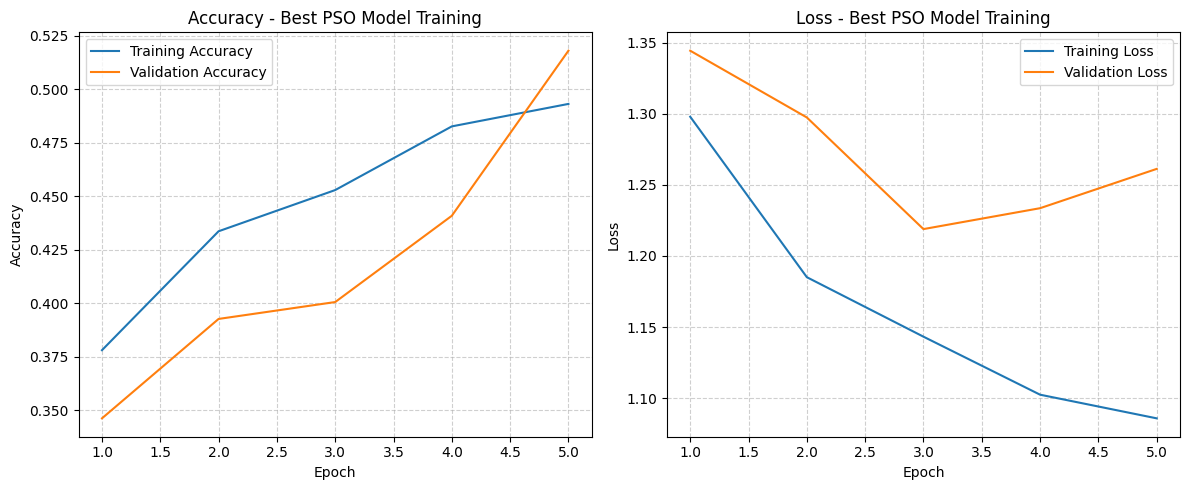

Max Validation Accuracy: 0.5179666876792908
Min Validation Loss: 1.2188769578933716


In [52]:
max_val_acc, min_val_loss = plot_training_history(
    history_pso,
    title="Best PSO Model Training",
    max_epochs=7
)

print("Max Validation Accuracy:", max_val_acc)
print("Min Validation Loss:", min_val_loss)


In [73]:
import matplotlib.pyplot as plt

def plot_pso_convergence(pso_history, title="PSO Convergence"):
    """
    Plots PSO convergence.

    pso_history : list of tuples
                  Each tuple: (iteration, best_score)
    """
    iterations = [h[0] for h in pso_history]  # iteration number
    best_scores = [h[1] for h in pso_history]  # best validation accuracy

    plt.figure(figsize=(7, 5))
    plt.plot(iterations, best_scores, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("Best Validation Accuracy")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


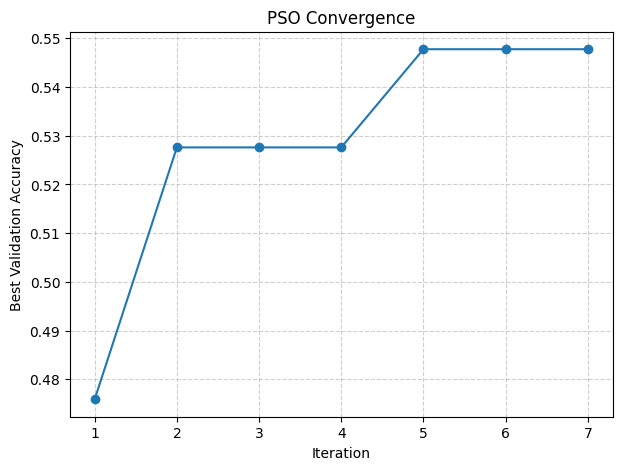

In [74]:
plot_pso_convergence(pso_history, title="PSO Convergence")


<Figure size 600x600 with 0 Axes>

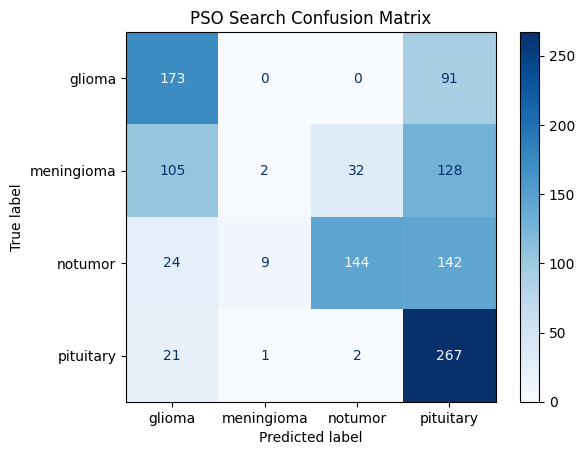

In [54]:
cm_pso = plot_confusion_matrix(
    model=pso_model,
    data_gen=val_gen,
    class_names=list(val_gen.class_indices.keys()),
    title="PSO Search Confusion Matrix"
)


---

# Visualize Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

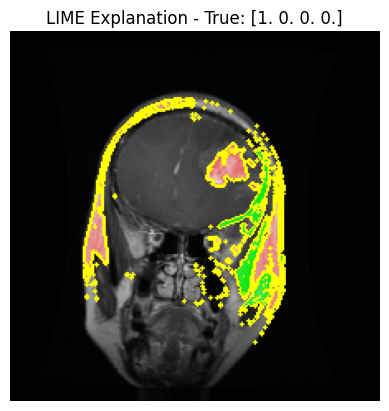

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

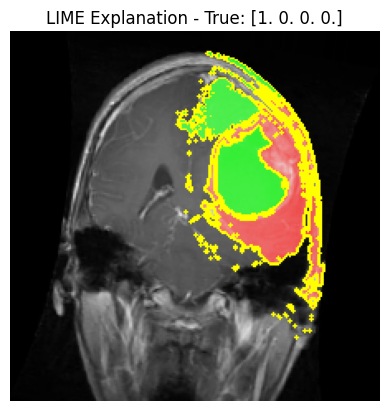

In [55]:
explain_with_lime(pso_model, val_gen, num_samples=2)

---

# Visualize Shap

Gathering data...
Data range in generator: 0.00 to 0.95
Computing SHAP for 2 images...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [01:12, 36.31s/it]


Plotting...


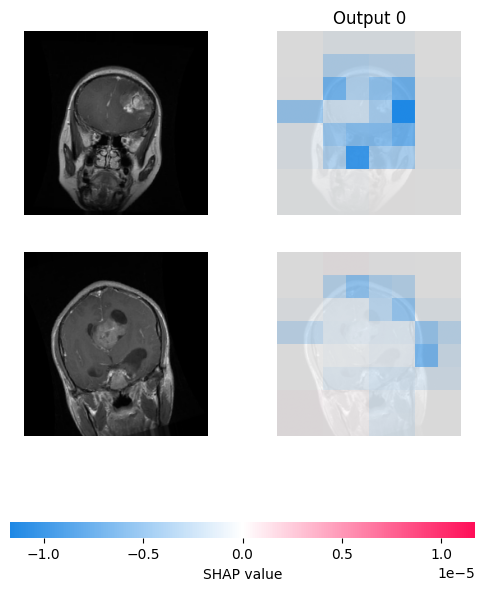

In [77]:
explain_with_shap_robust(pso_model, val_gen, num_samples=2)

# Visualize Deeplift

Running SmoothGrad (Denoised)...


/tmp/ipython-input-1897537378.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3]


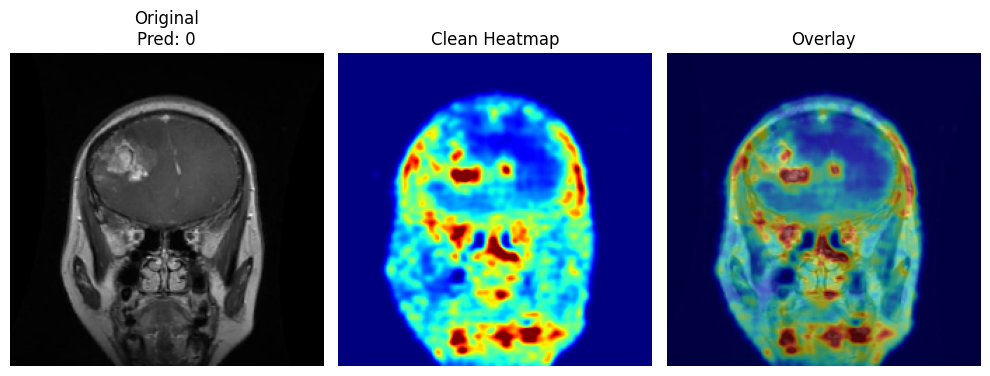

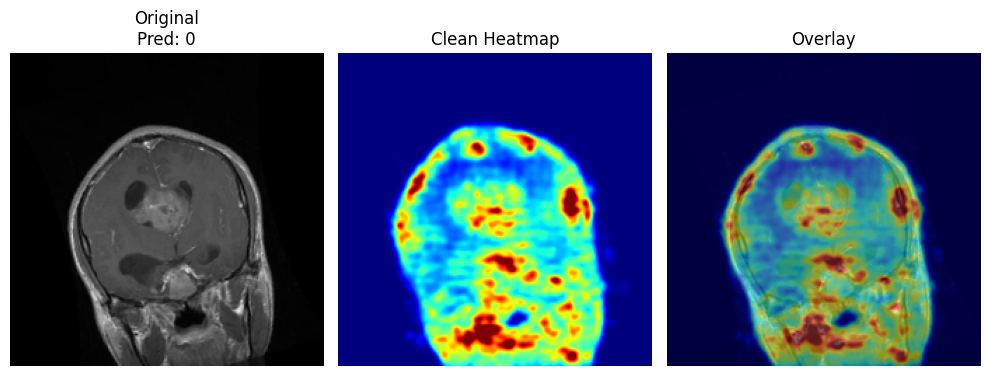

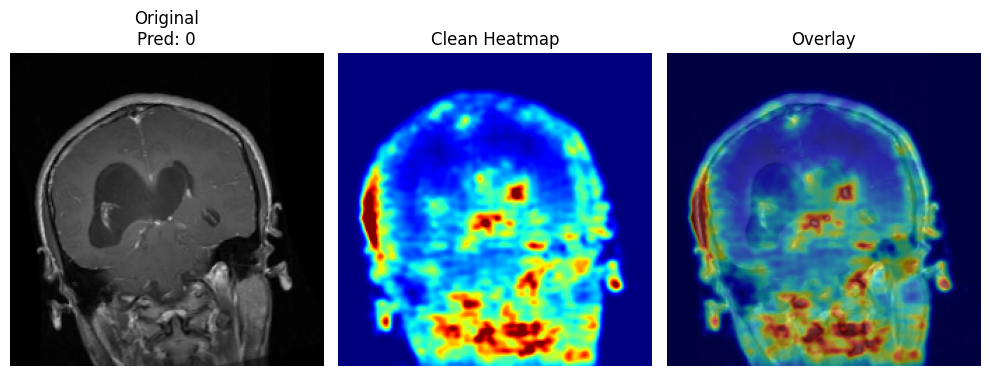

In [76]:

explain_smoothgrad_clean(pso_model, val_gen, num_samples=3)

---

# Visualize GradCam

Running Safe Polished Grad-CAM...
Image 0: Explaining Class 2


/tmp/ipython-input-2675675569.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


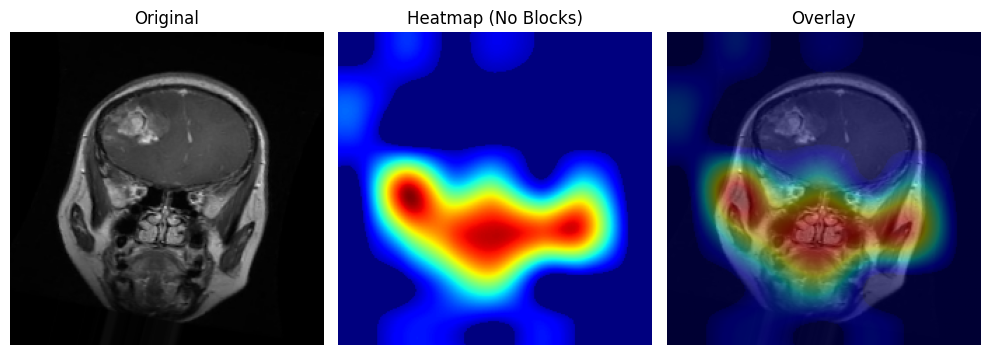

Image 1: Explaining Class 2


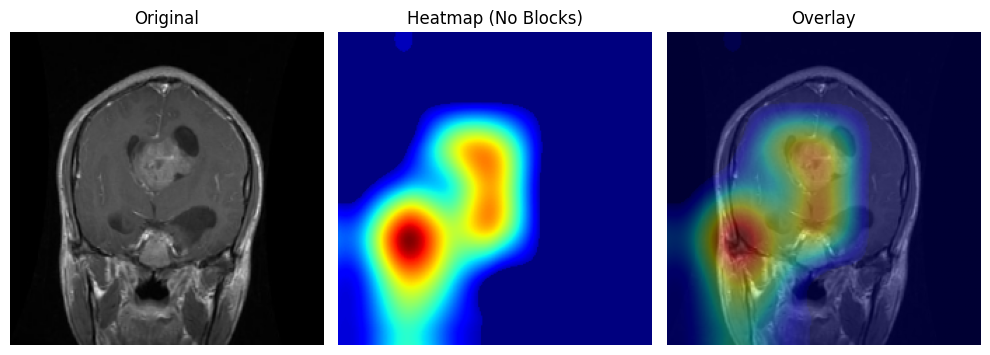

Image 2: Explaining Class 2


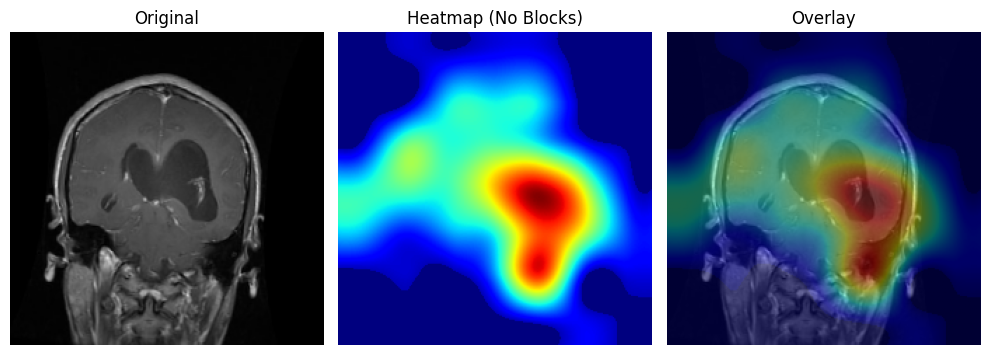

In [75]:
explain_gradcam_safe_polish(pso_model, val_gen, num_samples=3)